## Table of Contents

- [Prework](#Prework)
    - [Visualisaton for IV and HV](#Visualisaton_for_IV_and_HV)
        - [Summary statistics](#Summary_statistics)
        - [Data visualization](#Data_visualization)
        - [Stationarity check](#Stationarity_check)
        - [Performance metrics](#Performance_metrics)

- [Build Model](#Build_Model)
    - [Split trainning and testing dataset using VIX](#Split_trainning_and_testing_dataset_using_VIX)
    - [Benchmark - Multi-Layer Perceptron (MLP)](#Benchmark_Multi-Layer_Perceptron_(MLP))
    - [Build the ARIMA model using IV](#Build_the_ARIMA_model_using_IV)
    - [Build ANN model - LSTM](#Build_ANN_model_LSTM)
    - [Build ANN model - GRU](#Build_ANN_model_GRU)
    - [Build LSTM-ARIMA model](#Build_LSTM-ARIMA_model)
    - [Build ARIMA-LSTM model](#Build_ARIMA-LSTM_model)
    - [Build GRU-ARIMA model](#Build_GRU-ARIMA_model)
    - [Build ARIMA-GRU model](#Build_ARIMA-GRU_model)

- [Strategies](#Strategies)
    - [Combine models prediction results](#Combine_models_prediction_results)
    - [Evaluation method: index metrics](#Evaluation_method_index_metrics)



## Prework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.optimize import minimize
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.descriptivestats import describe
from statsmodels.tsa.stattools import adfuller as adf
import tensorflow as tf
import random as rn
import os
from scipy.stats import norm
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import arch
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
#Import data from downloaded excel files
Korea_file_path = r"F:\下载\dissertation\Korea.xlsx"

Korea = pd.read_excel(Korea_file_path, index_col="Date")


### Visualisaton_for_IV_and_HV

#### Summary_statistics

In [3]:
print(Korea['Price'].describe())

count    3706.000000
mean       17.720103
std         5.979494
min         9.720000
25%        13.730000
50%        16.550000
75%        19.730000
max        69.240000
Name: Price, dtype: float64


#### Data_visualization

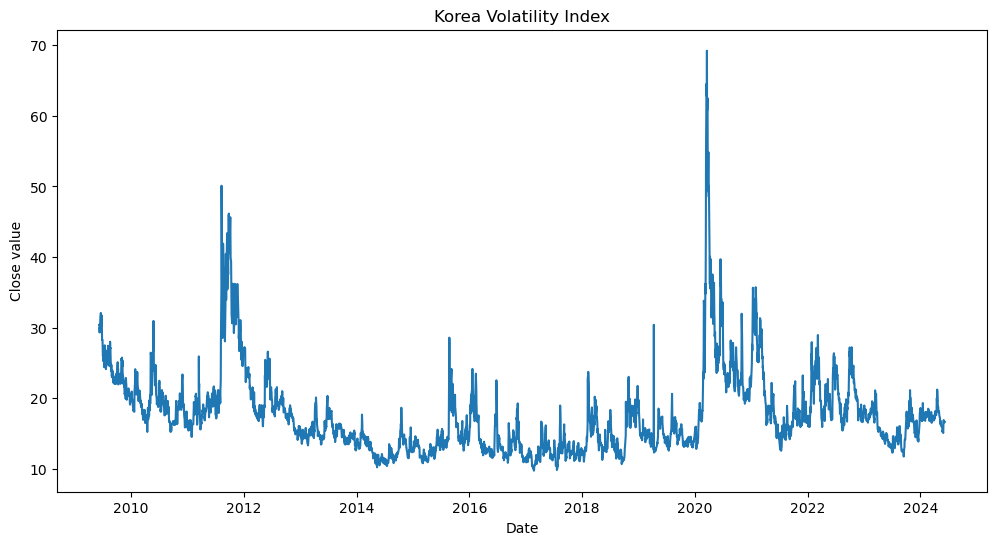

In [4]:
plt.figure(figsize=(12, 6))
# Create a line plot of the VIX close price
plt.plot(Korea.index, Korea['Price'])

# Set the title and axis labels
plt.title('Korea Volatility Index')
plt.xlabel('Date')
plt.ylabel('Close value')

# Display the plot
plt.show()

#### Stationarity_check

In [5]:
Korea_close = Korea['Price'].dropna()

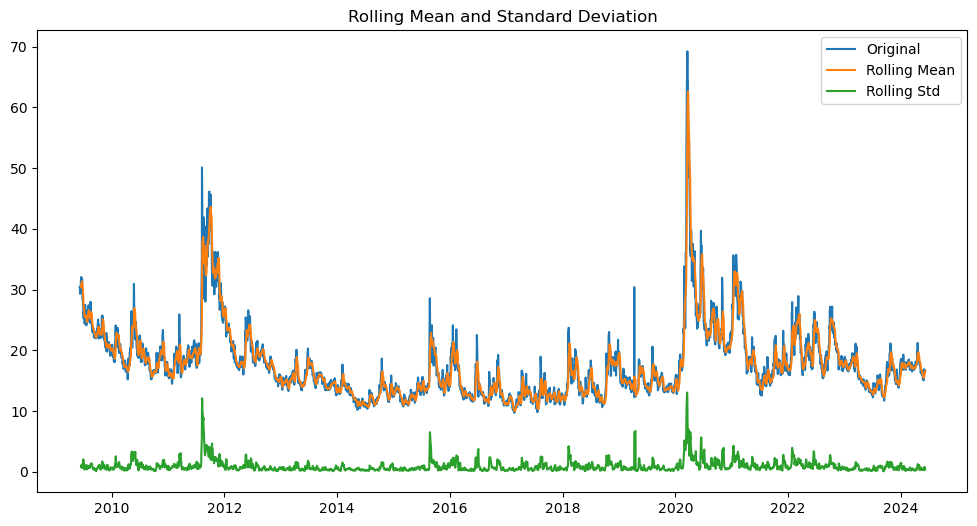

ADF Test Results:
ADF Statistic: -5.597015381156907
p-value: 1.2901379749880282e-06
Critical Values:
   1%: -3.432119084560324
   5%: -2.8623216835793537
   10%: -2.5671861014853827
KPSS Test Results:
KPSS Statistic: 0.7475915144228559
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\lenovo\AppData\Local\Temp\ipykernel_7620\2637001112.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c')


In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

# Plot rolling mean and standard deviation
def plot_rolling_statistics(timeseries, window=7):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    print("KPSS Test Results:")
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')

# Check stationarity by plotting rolling statistics and conducting tests
plot_rolling_statistics(Korea['Price'])

adf_test(Korea_close)

kpss_test(Korea_close)


#### Performance_metrics

In [7]:
# Calculate performance metrics
def evaluation(test_data, model_predictions):
    mse = mean_squared_error(test_data, model_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, model_predictions)
    r2 = r2_score(test_data, model_predictions)

    print("Performance Metrics:")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2) Score:", r2)

## Build_Model

### Split_trainning_and_testing_dataset_using_VIX

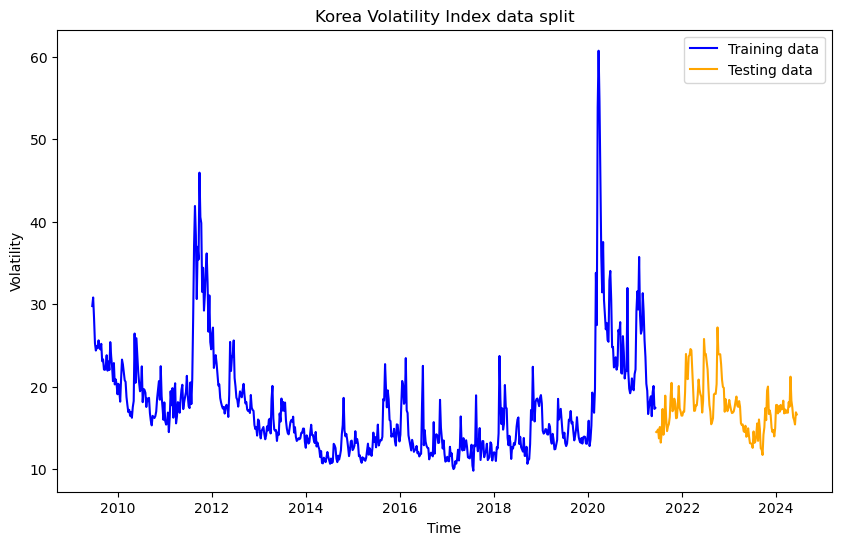

In [8]:
# Convert to the weekly dataset 
volatility_data = Korea['Price'].dropna().resample("W").last()
volatility_data = volatility_data.ffill()
# Split the data into training, validation and test sets
train_size = int(len(volatility_data)*0.8)
test_size = len(volatility_data) - train_size

train_data = volatility_data[:train_size]
test_data = volatility_data[train_size:]
train_dates = train_data.index
test_dates = test_data.index

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(train_data, label="Training data", color="blue")
plt.plot(test_data, label="Testing data", color="orange")
plt.title("Korea Volatility Index data split")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Benchmark_Multi-Layer_Perceptron_(MLP)

In [9]:
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Build the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(Dense(units=1))
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

# Train the MLP model
model_mlp.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for MLP (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Make predictions on the test data
predicted_values_mlp = model_mlp.predict(X_test)
predicted_values_mlp = scaler.inverse_transform(predicted_values_mlp)


Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130   
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.0071
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0059
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0059
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0036
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0052
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0044
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.0042
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.0044
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.0029   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


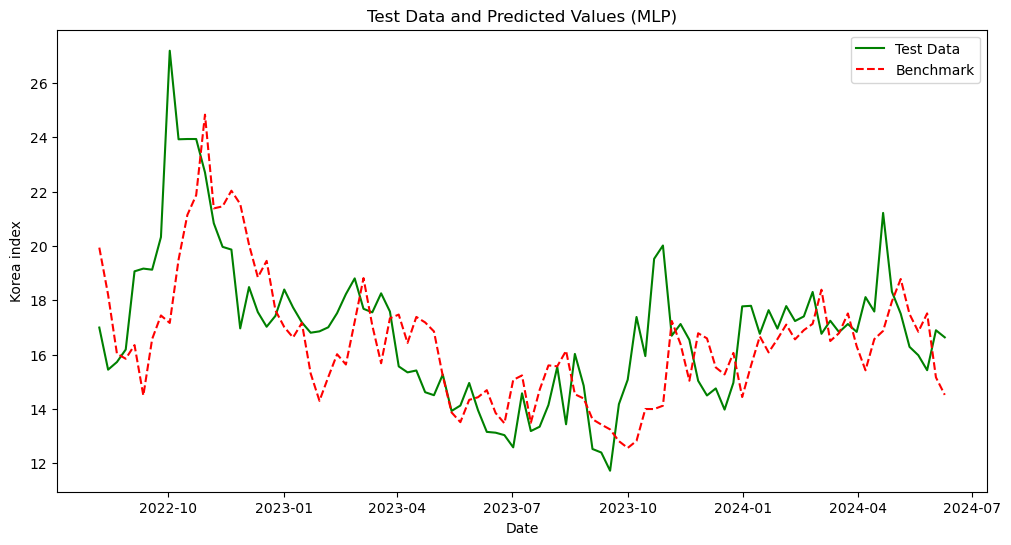

In [10]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='red', linestyle='dashed', label='Benchmark')
plt.title('Test Data and Predicted Values (MLP)')
plt.xlabel('Date')
plt.ylabel('Korea index')
plt.legend()
plt.show()

### Build_the_ARIMA_model_using_IV

Build a GARCH(1,1) model, and use the model to calculate fitted and predicted volatility of SP500 index. Plot the graph for original historical volatility and the predicted value, for the predicted value, use different color to show the fitted and predicted datasets.

In [11]:
# Train AutoARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2977.989, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3006.146, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2996.999, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2996.715, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3004.180, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2980.935, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2980.614, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2979.981, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2980.306, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2981.939, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2981.717, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2981.346, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2985.509, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2976.013, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
history = [x for x in train_data]
predicted_values_arima = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_7620\792924227.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


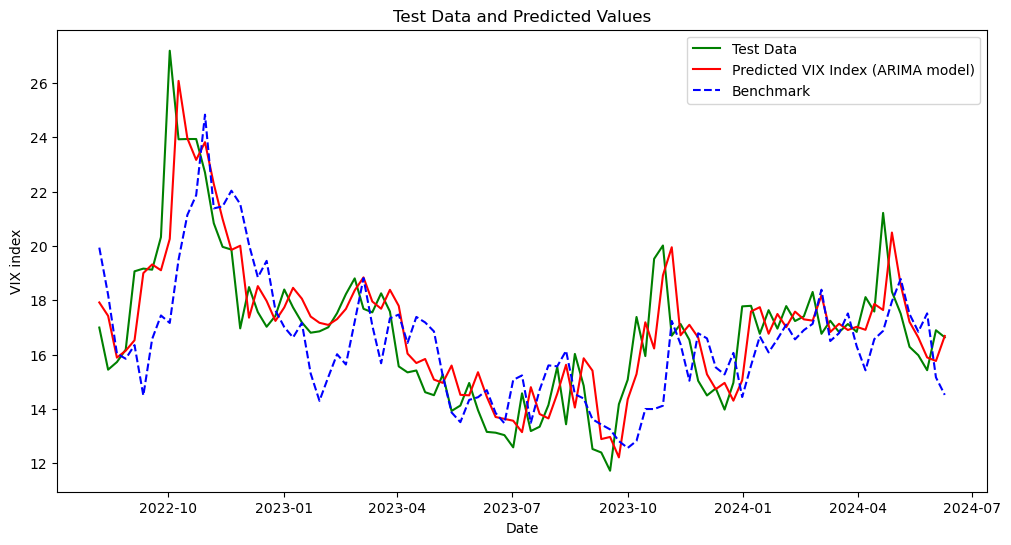

In [13]:
# Plot the graph
plt.figure(figsize=(12, 6))

# Plot the test data with a solid green line
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data', linestyle='-')

# Plot the predicted values from the ARIMA model with a dashed red line
plt.plot(test_dates[60:], predicted_values_arima[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA model)')

# Plot the predicted values from the MLP model with a dash-dot blue line
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('VIX index')

# Move the legend outside the plot area to avoid overlapping the lines
plt.legend()

plt.show()


In [14]:
evaluation(test_data, predicted_values_arima)

Performance Metrics:
Mean Squared Error (MSE): 2.8481331928602254
Root Mean Squared Error (RMSE): 1.6876413104863917
Mean Absolute Error (MAE): 1.2256263055519079
R-squared (R^2) Score: 0.6727941807006108


### Build_ANN_model_LSTM

In [ ]:
#Hyperparemeter tuning: grid search for hyperparameter tuning.

Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0214
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0096
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0064
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0080
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0107
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0076
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0089
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0052
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0078
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0399
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0132
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0096
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0091
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0134
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0076
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0077
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0082
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0108
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0069
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0035
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0036
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0032
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0216
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0074
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0060
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0091
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0058
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0046
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0078
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0081
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0065
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0243
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0115
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0112
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0065
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0089
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0064
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0059
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0089
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0066
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0119
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0040
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0045
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0031
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0024
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0027
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0235
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0095
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0037
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0034
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0258
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0101
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0045
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0042
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0175
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0023
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0344
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0113
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0094
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0065
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0034
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0058
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0035
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0023
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0046
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0033
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0929
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0100
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0149
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0070
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0072
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0055
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0064
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0061
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0039
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0454
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0045
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0033
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0032
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0029
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0032
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0025
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0026
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0028
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0025
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 10.7256
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0408
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0871
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0281
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0175
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0184
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0179
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0175
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0112
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.6249
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0246
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0274
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0297
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0239
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0244
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0195
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0277
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0289
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0235
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.8650 
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4565
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1579
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0582
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0291
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0167
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0118
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0112
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0133
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0129
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 17.1688
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2189
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0412
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0252
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0247
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0210
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0261
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0177
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0143
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0237
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 15.5734
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0433
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0182
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0123
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0174
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0140
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0136
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0081
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0228
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0159
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 16.0534
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.5226
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0754
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0180
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0215
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0183
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0164
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0108
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0157
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0141
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0238
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0085
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0129
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0078
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0094
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0120
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0064
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0063
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0057
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0082
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0038
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0065
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0056
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0057
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0053
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0347
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0116
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0114
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0091
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0073
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0081
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0085
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0085
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0071
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0094
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0064
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0053
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0060
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0080
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0122
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0060
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0040
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0039
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0033
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0215
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0110
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0064
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0068
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0103
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0071
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0053
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0038
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0042
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0054
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0034
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0066
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0051
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0054
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0295
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0114
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0077
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0063
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0101
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0089
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0057
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0061
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0080
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0051
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0079
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0080
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0050
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0058
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0060
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0125
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0055
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0036
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0030
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0033
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0026
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0025
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0025
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034
Epoc

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0143
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0055
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0095
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0025
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0036
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0041
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0040
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0046
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0042
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0375
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0090
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0078
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0067
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0064
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0062
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0043
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0042
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0039
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0041
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0039
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0167
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0042
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0040
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0024
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0024
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0345
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0094
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0082
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0083
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0056
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0050
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0030
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0030
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0027
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0029
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0043
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0034
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0028
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0031
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0995
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0106
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0094
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0074
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0089
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0068
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0068
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0047
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0034
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0029
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0035
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0037
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0335
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0070
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0054
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0035
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0026
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0029
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0026
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0022
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0030
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0023
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0020
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0022
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0015
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0022
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.1860
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0238
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0246
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0146
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0195
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0158
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0196
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0138
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0130
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0116
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0096
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0084
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0084
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0075
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0065
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.5589
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0593
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0380
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0226
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0183
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0212
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0192
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0219
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0220
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0183
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0226
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0235
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0219
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0232
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0200
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10.0014
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2609
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3047
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0330
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1715
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1980
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0734
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0189
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0148
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0122
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0136
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0094
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0107
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0112
Epoch 16/20
12

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 19.4598
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0299
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0183
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0141
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0185
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0168
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0154
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0124
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0139
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0110
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0056
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0106
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0059
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0212
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0164
Epoch 16/20
12

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.0971
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4504
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1232
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0430
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0420
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0371
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0296
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0198
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0196
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0195
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0243
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0222
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0241
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0222
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0398
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.7851
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3165
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1152
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0363
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0174
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0137
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0134
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0131
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0133
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0111
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0158
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0137
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0108
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0122
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0144
Epoch 16/20
12/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0201
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0123
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0129
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0069
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0081
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0077
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0097
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0057
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0077
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0058
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0374
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0160
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0106
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0109
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0104
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0100
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0083
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0103
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0157
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0074
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0061
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0038
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0047
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0054
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0202
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0102
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0094
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0082
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0096
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0054
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0071
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0066
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0052
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0056
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0331
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0138
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0077
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0119
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0112
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0085
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0096
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0080
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0071
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0086
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0201
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0057
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0049
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0040
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0042
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0028
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0033
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0030
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0036
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0035
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0243
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0058
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0055
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1108
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0229
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0124
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0160
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0117
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0079
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0067
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0083
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0066
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0217
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0090
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0046
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0035
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0022
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0031
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0029
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0027
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0466
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0118
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0128
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0069
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0094
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0059
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0049
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0045
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0051
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0040
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0505
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0152
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0089
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0082
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0078
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0072
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0048
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0060
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0042
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0034
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0328
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0077
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0045
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0038
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0029
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0032
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0029
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0024
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0024
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0021
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.7700
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0916
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0528
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0317
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0253
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0213
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0160
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0213
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0238
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0203
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.1092
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1132
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0373
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0249
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0282
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0219
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0248
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0202
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0188
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0177
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.6872
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1712
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1398
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1006
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0483
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0262
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0280
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0221
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0169
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0153
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 10.8233
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.4509
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0990
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1546
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1116
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0731
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0472
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0390
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0287
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0233
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 18.6575
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.1169
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.5259
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.4503
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.4251
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1303
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0574
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0455
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0372
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1492
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 21.6177
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.5839
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0317
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0144
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0208
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0166
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0133
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0133
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0110
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0102
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0211
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0153
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0123
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0091
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0069
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0070
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0083
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0070
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0093
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0077
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0055
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0062
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0060
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0422
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0130
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0094
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0141
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0090
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0119
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0095
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0123
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0110
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0107
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0067
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0088
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0098
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0081
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0065
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0139
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0078
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0059
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0050
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0038
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0042
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0030
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0192
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0137
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0098
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0084
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0068
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0063
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0053
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0055
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0051
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0052
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0048
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0062
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0048
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0045
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0062
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0282
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0158
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0170
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0117
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0100
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0089
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0093
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0066
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0074
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0072
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0081
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0088
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0078
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0071
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0079
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0168
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0056
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0058
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0049
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0039
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0034
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0028
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0036
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0040
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0034
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0031
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0028
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0026
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0029
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0027
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0287
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0096
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0079
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0067
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0042
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0042
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0059
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0027
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0679
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0189
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0156
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0122
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0090
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0084
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0068
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0071
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0064
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0043
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0238
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0108
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0030
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0028
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0028
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1005
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0143
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0079
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0084
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0070
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0093
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0062
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0048
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0042
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0058
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0044
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0059
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0055
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0038
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0042
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.1979
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0208
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0154
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0136
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0121
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0134
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0072
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0086
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0068
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0055
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0064
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0082
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0079
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0045
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0054
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0518
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0109
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0067
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0052
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0038
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0033
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0031
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0033
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0024
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0024
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0029
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0024
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0022
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0019
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0022
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.3366
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2782
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1399
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4003
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2961
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0580
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0308
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0214
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0162
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0189
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0173
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0188
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0139
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0173
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0156
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 10.8809
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2825
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3022
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0724
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0348
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0294
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0233
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0233
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0220
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0215
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0183
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0239
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0225
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0187
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0164
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.0219
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1064
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2287
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0183
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0548
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0495
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0185
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0136
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0166
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0123
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0116
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0171
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0145
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0159
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0128
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 23.0215
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 5.5737
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0950
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0172
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0165
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0180
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0157
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0134
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0130
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0116
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0116
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0152
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0087
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0079
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0132
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 11.8617
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2974
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1193
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0591
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0367
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0351
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0249
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0251
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0204
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0195
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0196
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0226
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0205
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0216
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0215
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 25.1765
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.7465
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0589
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0362
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0181
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0186
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0162
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0125
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0176
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0167
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0141
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0124
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0110
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0127
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0126
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0152
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0052
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0066
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0025
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0030
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027
Epoch 15/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032
Epoch 16/20
18/

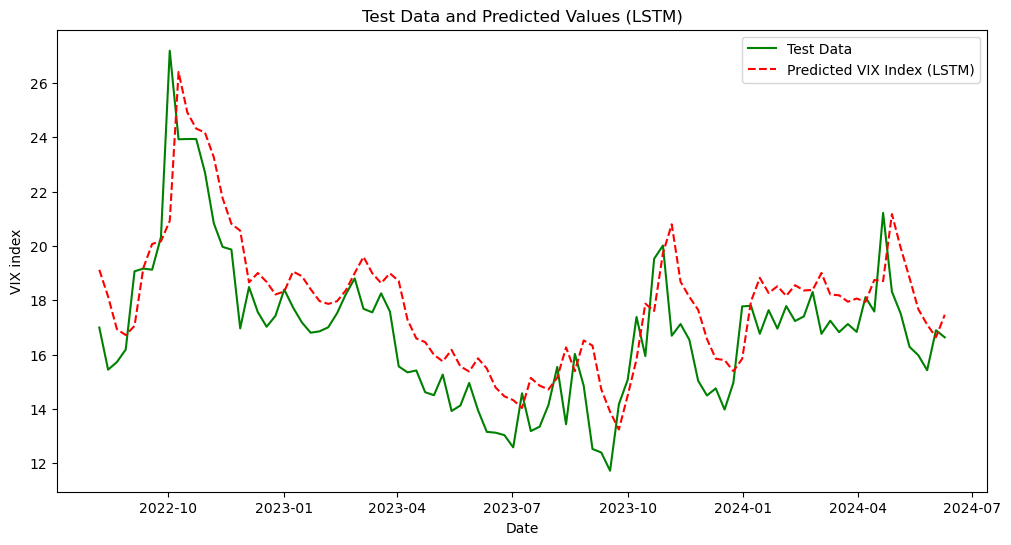

In [15]:
# Normalize the data
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_normalized, lookback)
X_test, y_test = create_sequences(test_data_normalized, lookback)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model as a scikit-learn estimator
regressor = KerasRegressor(model=create_lstm_model, units=50, learning_rate=0.001)

# Perform hyperparameter tuning using grid search
param_grid = {
    'model__units': [50, 100], 
    'batch_size': [32, 64], 
    'epochs': [10, 20], 
    'model__learning_rate': [0.001, 0.01, 0.1]
}
model = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3)
model.fit(X_train, y_train)

# Get the best hyperparameters
best_units = model.best_params_['model__units']
best_batch_size = model.best_params_['batch_size']
best_epochs = model.best_params_['epochs']
best_learning_rate = model.best_params_['model__learning_rate']

print(f"Best Hyperparameters: units={best_units}, batch_size={best_batch_size}, epochs={best_epochs}, learning_rate={best_learning_rate}")

# Train the LSTM model with the best hyperparameters
final_model = create_lstm_model(units=best_units, learning_rate=best_learning_rate)
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Make predictions on the test data
predicted_values_lstm = final_model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='dashed', label='Predicted VIX Index (LSTM)')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()



In [26]:
#Best Hyperparameters: units=50, batch_size=32, epochs=20, learning_rate=0.01

In [16]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0173
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0079
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0059
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0061
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0059
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0053
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0055
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0044
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0037
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029
Epoch 15/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0036
Epoch 16/20
18/

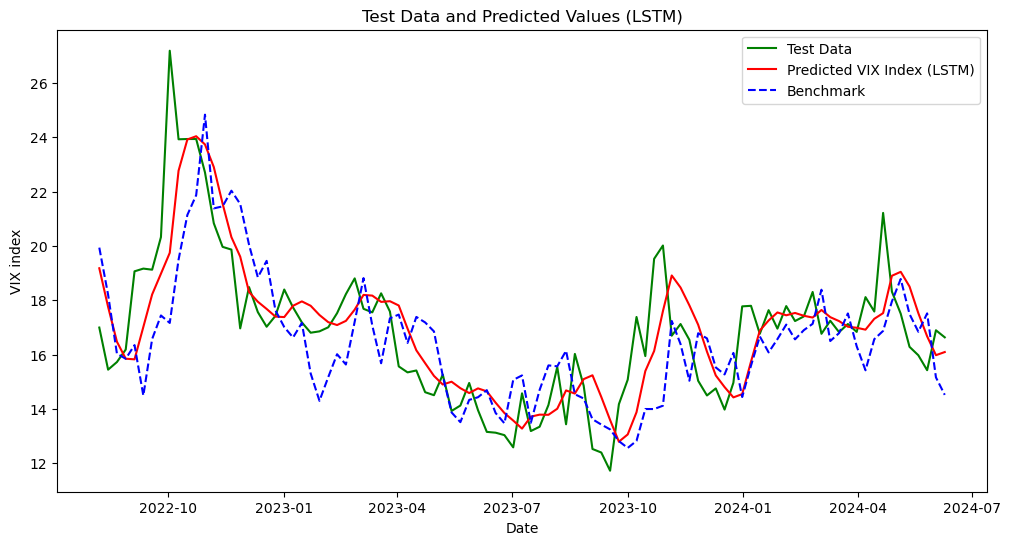

In [17]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='-', label='Predicted VIX Index (LSTM)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [18]:
evaluation(test_data[lookback:], predicted_values_lstm)

Performance Metrics:
Mean Squared Error (MSE): 2.530770320791648
Root Mean Squared Error (RMSE): 1.5908395018956651
Mean Absolute Error (MAE): 1.173097556202682
R-squared (R^2) Score: 0.6438479250762281


In [19]:
evaluation(test_data[lookback:], predicted_values_mlp)

Performance Metrics:
Mean Squared Error (MSE): 5.155723744521762
Root Mean Squared Error (RMSE): 2.2706218849737536
Mean Absolute Error (MAE): 1.7075459659222472
R-squared (R^2) Score: 0.2744415823673808


### Build_ANN_model_GRU

In [20]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru = model_gru.predict(X_test)
predicted_values_gru = scaler.inverse_transform(predicted_values_gru)


Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0134
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0050
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0045
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0064
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0038
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0041
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0044
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0041
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0036
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0032
Epoch 15/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0039
Epoch 16/20
18/

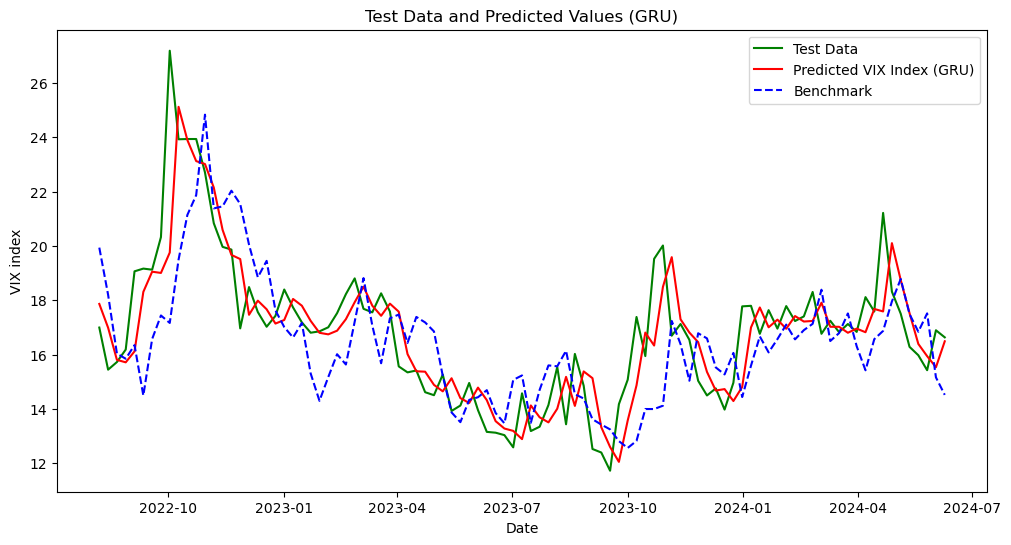

In [21]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru, color='red', linestyle='-', label='Predicted VIX Index (GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [22]:
evaluation(test_data[lookback:], predicted_values_gru)

Performance Metrics:
Mean Squared Error (MSE): 2.0258986693027645
Root Mean Squared Error (RMSE): 1.4233406722576167
Mean Absolute Error (MAE): 0.9965357739163431
R-squared (R^2) Score: 0.7148978677639197


### Build_LSTM-ARIMA_model

In [23]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=64)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm_arima = scaler.inverse_transform(model_lstm.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1389
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0696
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0266
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0407
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0351
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0223
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0243
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0253
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0240
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0233
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0255
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0207
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0211
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0227
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0213
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/

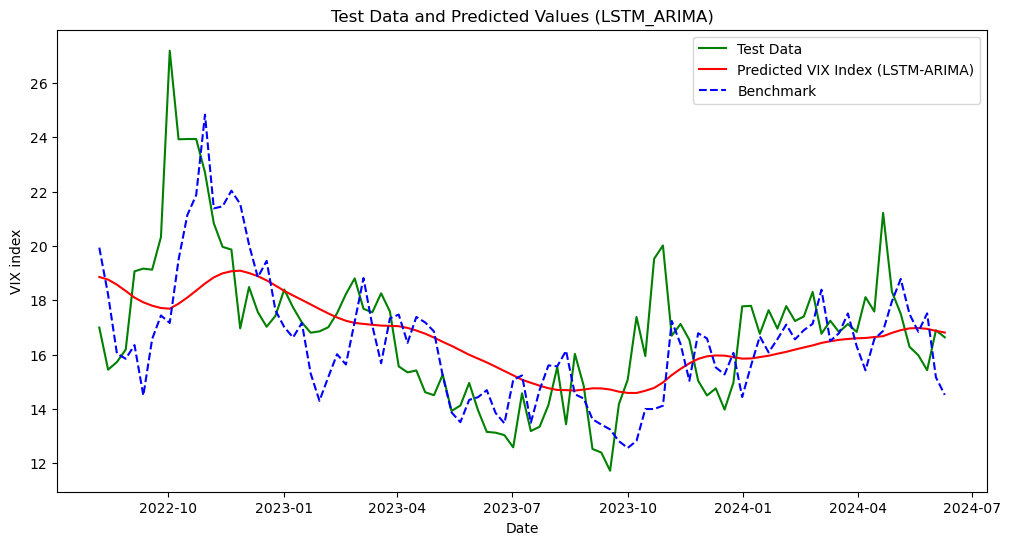

In [24]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm_arima, color='red', linestyle='-', label='Predicted VIX Index (LSTM-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (LSTM_ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()


In [25]:
evaluation(test_data[lookback:], predicted_values_lstm_arima)

Performance Metrics:
Mean Squared Error (MSE): 4.98701704325307
Root Mean Squared Error (RMSE): 2.233163013139227
Mean Absolute Error (MAE): 1.6818495079905715
R-squared (R^2) Score: 0.2981834609632995


### Build_ARIMA-LSTM_model

In [26]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_lstm]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=151.466, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=213.977, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=161.651, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=173.414, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=212.167, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=163.525, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=151.556, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=152.320, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=161.785, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=164.174, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=152.469, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=154.128, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=149.667, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=161.630, 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [27]:
#One_step ahead forecast
predicted_values_arima_lstm = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_lstm.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_7620\3412609831.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

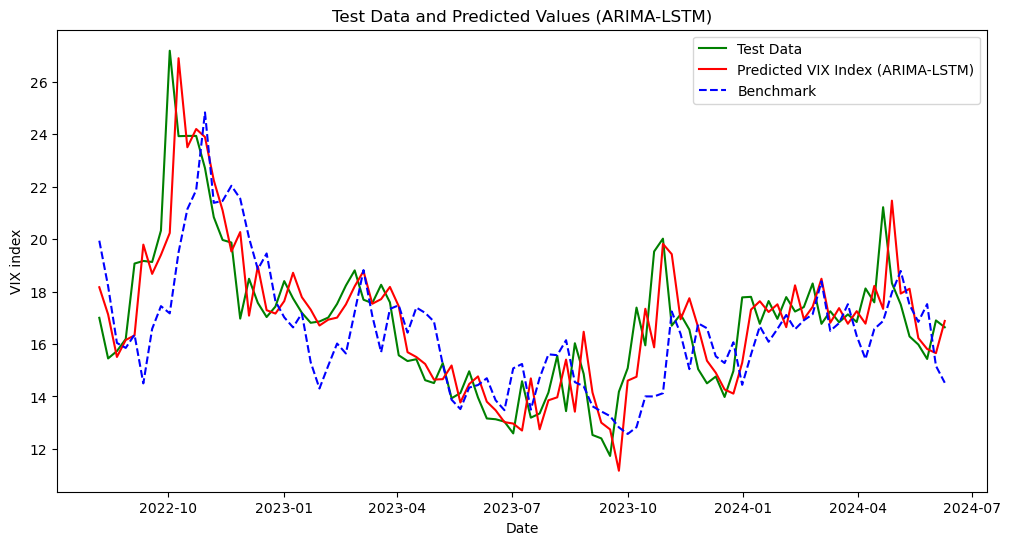

In [28]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_lstm[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-LSTM)')
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (ARIMA-LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [29]:
evaluation(test_data, predicted_values_arima_lstm)

Performance Metrics:
Mean Squared Error (MSE): 2.969810642147924
Root Mean Squared Error (RMSE): 1.723313854800664
Mean Absolute Error (MAE): 1.2776438780347659
R-squared (R^2) Score: 0.6588153507834402


### Build_GRU-ARIMA_model

In [30]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=64)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru_arima = scaler.inverse_transform(model_gru.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.1089
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0558
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0293
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0161
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0253
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0307
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0252
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0177
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0162
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0172
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0182
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0192
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0189
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0162
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0170
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/

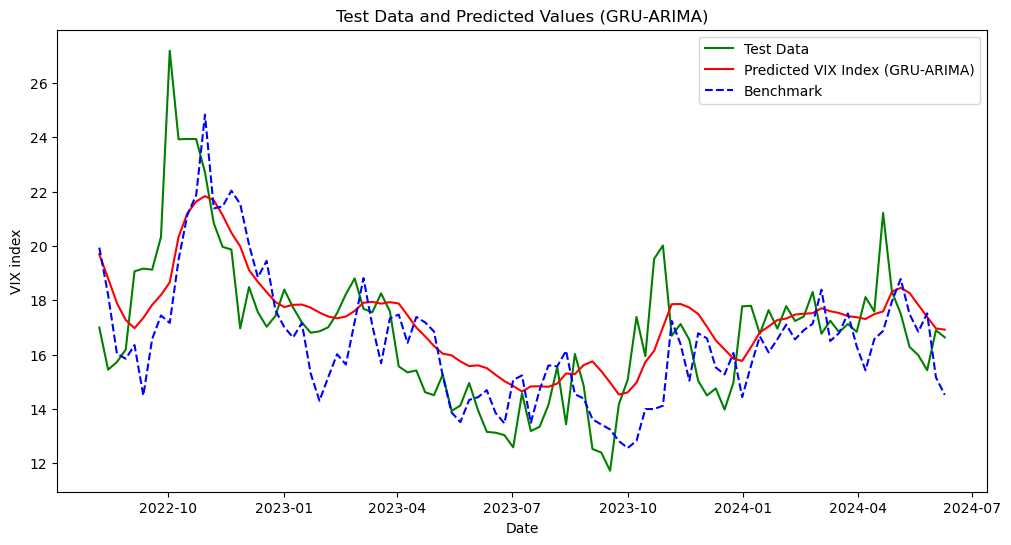

In [31]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru_arima, color='red', linestyle='-', label='Predicted VIX Index (GRU-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (GRU-ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
#plt.grid(True)
plt.show()

In [32]:
print(len(test_data))

157


In [33]:
print(len(predicted_values_gru_arima))

97


In [ ]:
evaluation(test_data, predicted_values_gru_arima)

### Build_ARIMA-GRU_model

In [35]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_gru]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=288.409, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=289.687, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=289.625, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=286.426, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=291.453, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [36]:
#One_step ahead forecast
predicted_values_arima_gru = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_gru.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_7620\220714338.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


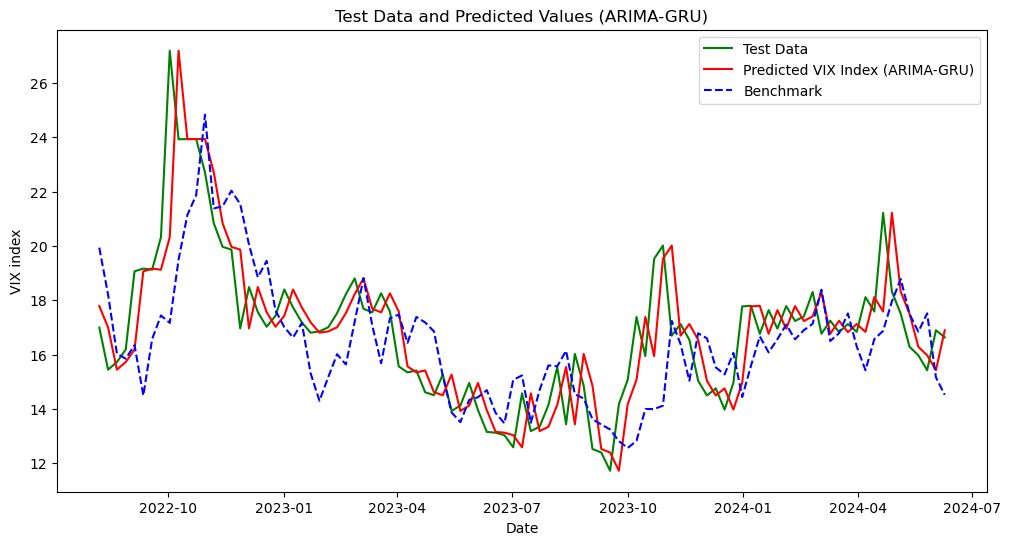

In [37]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_gru[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (ARIMA-GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [38]:
evaluation(test_data, predicted_values_arima_gru)

Performance Metrics:
Mean Squared Error (MSE): 2.924374464169752
Root Mean Squared Error (RMSE): 1.7100802507981174
Mean Absolute Error (MAE): 1.222638603744993
R-squared (R^2) Score: 0.6640352547817677


## Strategies

### Combine_models_prediction_results

In [39]:
y_lstm = pd.Series([x[0] for x in predicted_values_lstm], index = test_dates[60:])
y_lstm_arima = pd.Series([x[0] for x in predicted_values_lstm_arima], index = test_dates[60:])
y_arima_lstm = pd.Series(predicted_values_arima_lstm[60:],index =test_dates[60:])
y_gru = pd.Series([x[0] for x in predicted_values_gru], index = test_dates[60:])
y_gru_arima = pd.Series([x[0] for x in predicted_values_gru_arima], index = test_dates[60:])
y_arima_gru = pd.Series(predicted_values_arima_gru[60:],index =test_dates[60:])
y_benchmark = pd.Series([x[0] for x in predicted_values_mlp], index = test_dates[60:])
y_test = test_data[60:]

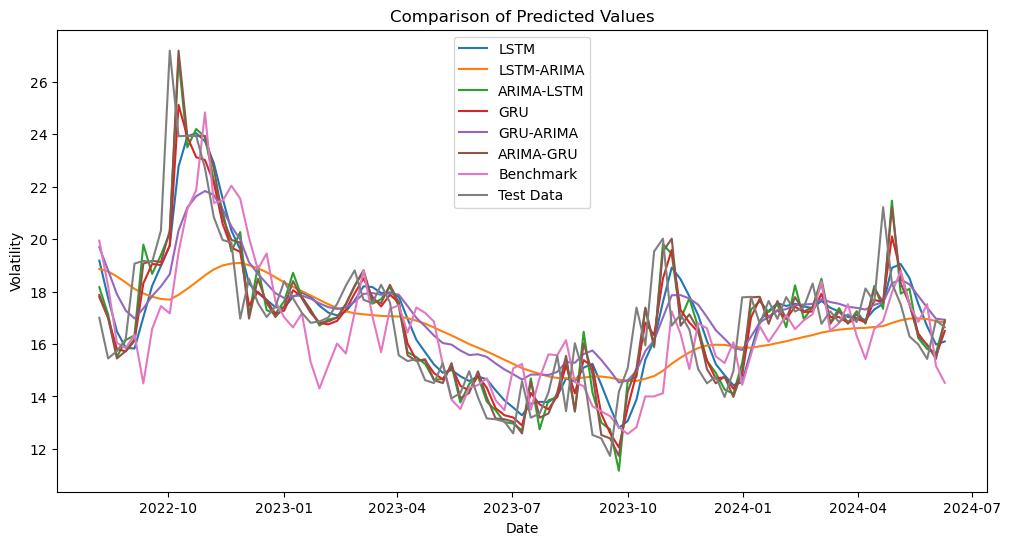

In [40]:
plt.figure(figsize=(12, 6))
# Plot the y-values
plt.plot(y_lstm, label='LSTM')
plt.plot(y_lstm_arima, label='LSTM-ARIMA')
plt.plot(y_arima_lstm, label='ARIMA-LSTM')
plt.plot(y_gru, label='GRU')
plt.plot(y_gru_arima, label='GRU-ARIMA')
plt.plot(y_arima_gru, label='ARIMA-GRU')
plt.plot(y_benchmark, label='Benchmark')
plt.plot(y_test, label='Test Data')

# Set the title and labels
plt.title('Comparison of Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# Display the plot
plt.show()

In [41]:
models = ["Benchmark",'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test_data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

data_vol = {model: prediction for model, prediction in zip(models, predictions)}

# Create the DataFrame
df_vol = pd.DataFrame(data_vol)

In [42]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2022-08-07,19.942047,19.182560,18.861980,18.166322,17.869461,19.694574,17.79,17.00
2022-08-14,18.206226,17.760511,18.765732,17.128550,16.994053,18.811613,17.00,15.45
2022-08-21,16.041691,16.480265,18.579264,15.506242,15.810758,17.900890,15.45,15.73
2022-08-28,15.851309,15.853407,18.347586,16.153373,15.719716,17.279047,15.73,16.19
2022-09-04,16.353884,15.829624,18.103273,16.329504,16.123808,16.975939,16.19,19.07
...,...,...,...,...,...,...,...,...
2024-05-12,17.497112,18.510490,16.970385,18.107627,17.531122,18.274912,17.51,16.29
2024-05-19,16.846037,17.530346,16.982441,16.225532,16.396578,17.832554,16.29,15.98
2024-05-26,17.521776,16.676104,16.951265,15.810127,15.946301,17.390272,15.98,15.43


### Evaluation_method_index_metrics

In [43]:
#Evaluation method 1: index metrics (Prediction accuracy) Ref: Main1
#1 Testing accuracy ratio for modelling (bar plot/box plot)
#2 MSE, RMSE, MAE, etc...

In [55]:
# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity', 'R-squared']
results = []

for column in df_vol.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_vol[column]
    test_data = df_vol['Test_data']
    
    # Calculate statistical measures
    mse = np.mean((model_data - test_data) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - test_data))
    correlation = np.corrcoef(model_data, test_data)[0, 1]
    cosine_similarity = np.dot(model_data, test_data) / (np.linalg.norm(model_data) * np.linalg.norm(test_data))
    
    # Calculate R-squared
    ss_res = np.sum((test_data - model_data) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity, r_squared])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_vol.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_vol = df_results.sort_values(by='MSE', ascending=True)

In [56]:
df_results_sorted_vol

,MSE,RMSE,MAE,Correlation,Cosine Similarity,R-squared
GRU,2.025899,1.423341,0.996536,0.847590,0.996524,0.714898
ARIMA_GRU,2.233700,1.494557,1.050000,0.842929,0.996170,0.685654
ARIMA_LSTM,2.279562,1.509822,1.071464,0.839095,0.996100,0.679200
LSTM,2.530770,1.590840,1.173098,0.805784,0.995662,0.643848
GRU_ARIMA,3.444972,1.856064,1.409737,0.744606,0.994290,0.515193
LSTM_ARIMA,4.987017,2.233163,1.681850,0.555387,0.991489,0.298183
Benchmark,5.155724,2.270622,1.707546,0.597987,0.991258,0.274442


In [57]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2022-08-07,19.942047,19.182560,18.861980,18.166322,17.869461,19.694574,17.79,17.00
2022-08-14,18.206226,17.760511,18.765732,17.128550,16.994053,18.811613,17.00,15.45
2022-08-21,16.041691,16.480265,18.579264,15.506242,15.810758,17.900890,15.45,15.73
2022-08-28,15.851309,15.853407,18.347586,16.153373,15.719716,17.279047,15.73,16.19
2022-09-04,16.353884,15.829624,18.103273,16.329504,16.123808,16.975939,16.19,19.07
...,...,...,...,...,...,...,...,...
2024-05-12,17.497112,18.510490,16.970385,18.107627,17.531122,18.274912,17.51,16.29
2024-05-19,16.846037,17.530346,16.982441,16.225532,16.396578,17.832554,16.29,15.98
2024-05-26,17.521776,16.676104,16.951265,15.810127,15.946301,17.390272,15.98,15.43


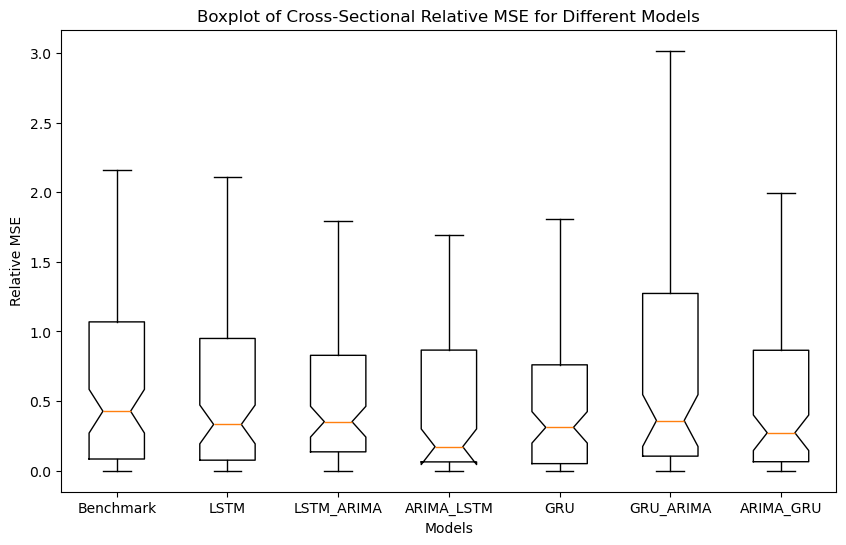

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative MSE for each model
models = df_vol.columns[:-1]  # Extract the model names from df_vol
relative_mse_values = []

for model in models:
    mse_values = (df_vol['Test_data'] - df_vol[model]) ** 2
    relative_mse = mse_values / np.mean(mse_values)
    relative_mse_values.append(relative_mse)

# Create boxplots of relative MSE for different models
plt.figure(figsize=(10, 6))
plt.boxplot(relative_mse_values, vert=True, showfliers=False, notch=True, labels=models)
plt.xlabel('Models')
plt.ylabel('Relative MSE')
plt.title('Boxplot of Cross-Sectional Relative MSE for Different Models')
plt.show()
